# Implementing and Exploring Auto-Regressive (AR) models


## Part 1: Setup
### Import necessary libraries

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

import os
from datetime import datetime


### Load MNIST dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 338kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.55MB/s]


In [ ]:
print(train_loader.dataset)
print(test_loader.dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


## Part 2: Explore and visualize data
### Visualize samples

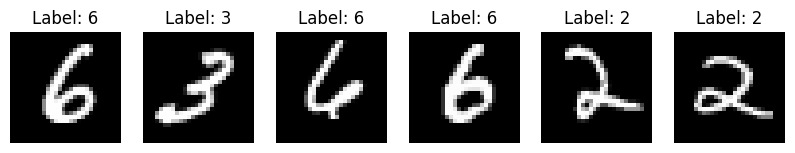

In [ ]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 6, figsize=(10, 3))
for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Label: {labels[i].item()}')
plt.show()

### Selective subset training
For a faster training, only train ona subset of images from each digit (class)

In [ ]:
samples_per_class = 1000
torch.manual_seed(123)

targets = train_dataset.targets
indices = []

for class_label in range(10):
    class_indices = torch.where(targets == class_label)[0]
    selected_indices = class_indices[torch.randperm(len(class_indices))[:samples_per_class]]
    indices.extend(selected_indices.tolist())

train_subset = Subset(train_dataset, indices)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)

### Selective digit training
For even faster training practice, only focus on a subset of digits that are easier to learn

In [ ]:
digit_filter = [1, 7]

filtered_indices = []

for idx in train_subset.indices:
    label = train_dataset.targets[idx].item()
    if label in digit_filter:
        filtered_indices.append(idx)

train_focused = Subset(train_dataset, filtered_indices)


filtered_indices = [i for i, label in enumerate(test_dataset.targets) if label in digit_filter]
test_focused = Subset(test_dataset, filtered_indices)

training_focused_loader = DataLoader(train_focused, batch_size=128, shuffle = True)
test_focused_loader = DataLoader(test_focused, batch_size = 128, shuffle = True)

## Part 3: Implement AR

In [ ]:
class NADE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=512):
        """Initialize the Neural Autoregressive Density Estimation model.

        Args:
            input_dim (int): Dimension of input data (flattened image size)
            hidden_dim (int): Number of units in hidden layer
        """
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.W = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.01)
        self.c = nn.Parameter(torch.zeros(hidden_dim))
        self.V = nn.Parameter(torch.randn(hidden_dim, input_dim) * 0.01)
        self.b = nn.Parameter(torch.zeros(input_dim))

        # Training metadata
        self.start_epoch = 0
        self.best_loss = float('inf')
        self.train_history = []
        self.test_history = []

    def forward(self, x):
        """Forward pass through the NADE model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim)

        Returns:
            tuple: (x_hat, all_h) where:
                x_hat: reconstructed probabilities for each dimension
                all_h: all hidden states during autoregressive process
        """
        batch_size = x.size(0)
        x_hat = torch.zeros_like(x)
        all_h = []

        sum_to_d = torch.zeros(batch_size, self.hidden_dim, device=x.device)

        for d in range(self.input_dim):
            # Compute hidden activation: a_d = c + sum_{k<d} x_k * W_k
            a_d = self.c + sum_to_d
            h_d = torch.sigmoid(a_d)

            # Compute output probability for dimension d:
            # p_d = sigmoid(b_d + V_d^T h_d)
            p_d = torch.sigmoid(self.b[d] + torch.matmul(h_d, self.V[:, d]))

            # Save prediction
            x_hat[:, d] = p_d
            all_h.append(h_d)

            # Update running sum for the next dimension
            sum_to_d += x[:, d].unsqueeze(1) * self.W[d]

        return x_hat, torch.stack(all_h, dim=1)

    def log_prob(self, x):
        """Compute log probability of input samples under the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim)

        Returns:
            torch.Tensor: Log probabilities for each sample (batch_size)
        """
        x_hat, _ = self.forward(x)
        # Compute Bernoulli log likelihood:
        # log p(x) = sum_d [x_d * log(p_d) + (1-x_d) * log(1-p_d)]  --- update this in order to avoid log of zero

        x_hat = torch.clamp(x_hat, min=1e-6, max=1 - 1e-6) # avoid log(0)
        log_prob = x * torch.log(x_hat) + (1 - x) * torch.log(1 - x_hat)
        # Sum over all dimensions (input_dim)
        return log_prob.sum(dim=1)


    def generate_samples(self, num_samples=10):
        """
        Generates new images via ancestral sampling
        Args:
            num_samples: How many images to generate
        Returns:
            Tensor of shape (num_samples, input_dim)
        """
        samples = torch.zeros(num_samples, 784).to(device)
        with torch.no_grad():
            for d in range(784):
                p_d = self.forward(samples)[0][:, d]
                samples[:, d] = torch.bernoulli(p_d)
        return samples.cpu()


In [ ]:
# The code runs faster if you run on GPU. Select Runtime -> Change runtime type -> T4 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Part 4: Train the model


In [ ]:
model = NADE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 300
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch, _ in training_focused_loader:
        batch = batch.view(-1, 784).to(device)
        optimizer.zero_grad()
        loss = -model.log_prob(batch).mean()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation: similar to training, except no optimization and backward steps
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch, _ in test_loader:
            batch = batch.view(-1, 784).to(device)
            loss = -model.log_prob(batch).mean()
            test_loss += loss.item()
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)


    # For each epoch, print: epoch number, training loss, and test loss
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")


Epoch [1/300] - Train Loss: 98.3734 | Test Loss: 440.7101
Epoch [2/300] - Train Loss: 77.6075 | Test Loss: 366.6867
Epoch [3/300] - Train Loss: 62.7347 | Test Loss: 318.1212
Epoch [4/300] - Train Loss: 52.8692 | Test Loss: 289.0610
Epoch [5/300] - Train Loss: 46.5375 | Test Loss: 272.6746
Epoch [6/300] - Train Loss: 42.4725 | Test Loss: 263.4090
Epoch [7/300] - Train Loss: 39.8448 | Test Loss: 257.8155
Epoch [8/300] - Train Loss: 38.0174 | Test Loss: 254.3635
Epoch [9/300] - Train Loss: 36.6850 | Test Loss: 252.0216
Epoch [10/300] - Train Loss: 35.7120 | Test Loss: 250.6316
Epoch [11/300] - Train Loss: 34.9485 | Test Loss: 249.3504
Epoch [12/300] - Train Loss: 34.3428 | Test Loss: 248.3810
Epoch [13/300] - Train Loss: 33.8061 | Test Loss: 247.6267
Epoch [14/300] - Train Loss: 33.4334 | Test Loss: 247.1188
Epoch [15/300] - Train Loss: 33.0776 | Test Loss: 246.5497
Epoch [16/300] - Train Loss: 32.7508 | Test Loss: 245.9850
Epoch [17/300] - Train Loss: 32.5001 | Test Loss: 245.5269
Epoch 

# Part 5: Analyze Results


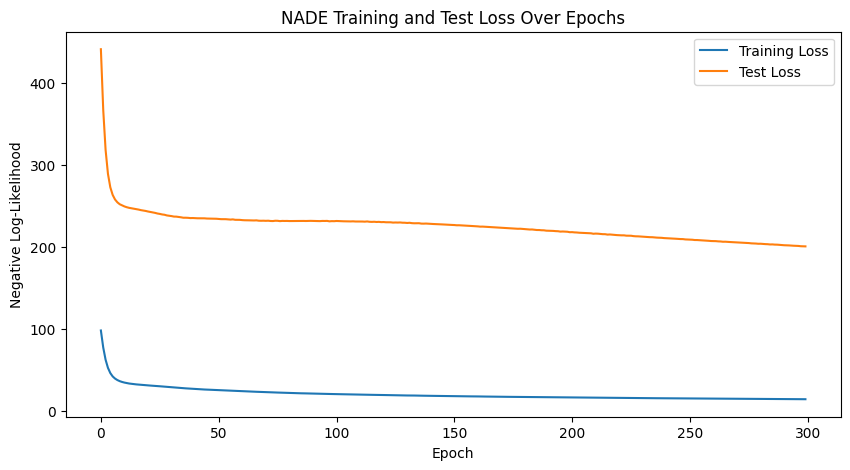

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.legend()
plt.title('NADE Training and Test Loss Over Epochs')
plt.show()

### Both training loss and test loss have converged based on the plot above. The scale in training loss scale is a bit different from the test loss scale; this is due to the normalizing term in the loss terms.

# Part 6: Generate and visualize samples


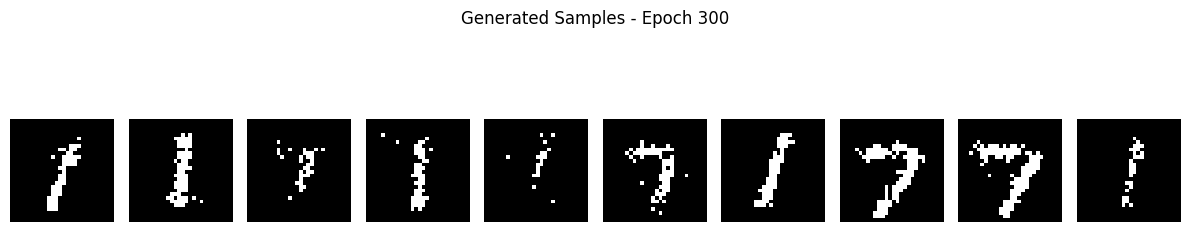

In [ ]:
samples = model.generate_samples()
plt.figure(figsize=(12, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(samples[i].view(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle(f"Generated Samples - Epoch {epoch+1}")
plt.tight_layout()
plt.show()

# Part 7: Bonus

1. Model Implementation
Implement an FVSBN model using the same filtered MNIST dataset. Carefully analyze how the autoregressive structure differs in implementation from NADE, particularly in how conditional dependencies are modeled between pixels. What modifications were required in the training loop to accommodate these architectural differences?

2. Architectural Comparison
Compare and contrast the model structures of FVSBN and NADE by addressing:

  (a) How the conditional probability p(x_i|x_<i) is computed differently in each architecture

  (b) The role of hidden units in NADE versus direct parameterization in FVSBN

  (c) The memory requirements for each model given an input dimension D. Support your analysis with specific equations from both architectures.

3. Empirical Evaluation
Design a systematic comparison between your trained FVSBN and NADE models by evaluating:

  (a) Training convergence rates using identical hyperparameters

  (b) Sample quality through both visual inspection and quantitative metrics (e.g., log-likelihood on test set)

  (c) Computational efficiency during both training and generation. What fundamental architectural characteristics explain the performance differences you observe?

In [ ]:
class FVSBN(nn.Module):
    def __init__(self, input_dim=784):
        super().__init__()
        self.input_dim = input_dim

        self.W = nn.Parameter(torch.tril(torch.randn(input_dim, input_dim) * 0.01, diagonal=-1))
        self.b = nn.Parameter(torch.zeros(input_dim))

    def forward(self, x):
        """
        Args:
            x: (batch_size, input_dim), binary input
        Returns:
            x_hat: (batch_size, input_dim), conditional probabilities of x_d given x_{<d}
        """
        logits = self.b + x @ self.W.T
        x_hat = torch.sigmoid(logits)
        return x_hat

    def log_prob(self, x):
        """
        Compute log probability of each input under the model.
        """
        x_hat = self.forward(x)
        x_hat = torch.clamp(x_hat, min=1e-6, max=1 - 1e-6)
        log_prob = x * torch.log(x_hat) + (1 - x) * torch.log(1 - x_hat)
        return log_prob.sum(dim=1)

    def generate_samples(self, num_samples=10):
        """
        Generate samples using ancestral sampling.
        """
        samples = torch.zeros(num_samples, self.input_dim).to(next(self.parameters()).device)
        with torch.no_grad():
            for d in range(self.input_dim):
                logits = self.b[d] + torch.matmul(samples, self.W[d])
                p_d = torch.sigmoid(logits)
                samples[:, d] = torch.bernoulli(p_d)
        return samples.cpu()

### To reach an FVSBN model from the NADE model, we need to delete the hidden layer(s) and I defined a triangular matrix for the parameters to consider the chain rule structure. </br> As FVSBN only uses logistic regression to approximate the conditional probabilities, there are no hidden layers and nonlinearities here. So the model as a whole is much simpler in complexity and also faster to train. As we have less parameters in FVSBN, it is more memory-efficient as we no longer have parameters for the hidden layer(s).

In [ ]:
model = FVSBN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 300
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch, _ in training_focused_loader:
        batch = batch.view(-1, 784).to(device)
        optimizer.zero_grad()
        loss = -model.log_prob(batch).mean()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation: similar to training, except no optimization and backward steps
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch, _ in test_loader:
            batch = batch.view(-1, 784).to(device)
            loss = -model.log_prob(batch).mean()
            test_loss += loss.item()
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)


    # For each epoch, print: epoch number, training loss, and test loss
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")


Epoch [1/300] - Train Loss: 106.5299 | Test Loss: 501.1925
Epoch [2/300] - Train Loss: 99.2218 | Test Loss: 464.0346
Epoch [3/300] - Train Loss: 92.6283 | Test Loss: 432.0261
Epoch [4/300] - Train Loss: 86.7269 | Test Loss: 404.7004
Epoch [5/300] - Train Loss: 81.4968 | Test Loss: 381.5408
Epoch [6/300] - Train Loss: 76.7718 | Test Loss: 361.8986
Epoch [7/300] - Train Loss: 72.5812 | Test Loss: 345.1146
Epoch [8/300] - Train Loss: 68.7948 | Test Loss: 330.7447
Epoch [9/300] - Train Loss: 65.4328 | Test Loss: 318.4880
Epoch [10/300] - Train Loss: 62.3564 | Test Loss: 307.9409
Epoch [11/300] - Train Loss: 59.6217 | Test Loss: 298.8321
Epoch [12/300] - Train Loss: 57.1515 | Test Loss: 290.9587
Epoch [13/300] - Train Loss: 54.8335 | Test Loss: 284.0816
Epoch [14/300] - Train Loss: 52.7770 | Test Loss: 278.0727
Epoch [15/300] - Train Loss: 50.9017 | Test Loss: 272.7639
Epoch [16/300] - Train Loss: 49.1566 | Test Loss: 268.1373
Epoch [17/300] - Train Loss: 47.5617 | Test Loss: 264.0852
Epoch

## Analyze Results

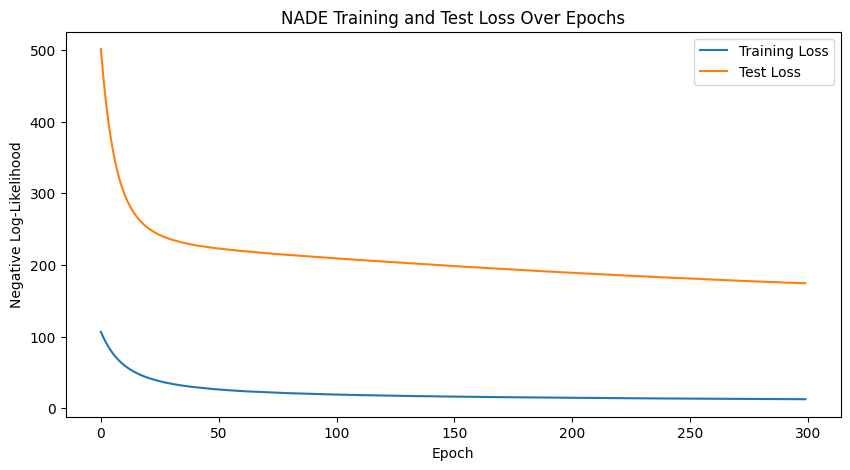

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.legend()
plt.title('NADE Training and Test Loss Over Epochs')
plt.show()

## Generate & Visualize Samples

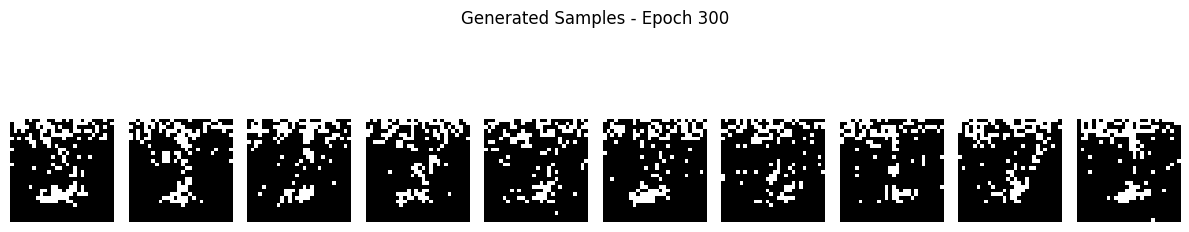

In [ ]:
samples = model.generate_samples()
plt.figure(figsize=(12, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(samples[i].view(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle(f"Generated Samples - Epoch {epoch+1}")
plt.tight_layout()
plt.show()

### As we expected, the quality of the generated samples are way lower comparing to NADE; this is clearly because of the lost complexity and nonlinearities that were accounted for in the NADE model structure.